# Forecasting Columbia River Hydropower Generation Using Vector AutoRegression

## **What is Vector AutoRegression (VAR)?**

VAR (Vector AutoRegression) is a multivariate time-series forecasting method that models the relationships between multiple time-dependent variables. Unlike simple Autoregressive (AR) models, which predict future values based on past values of a single variable, VAR uses multiple variables that influence each other.

In this case, we are forecasting Columbia River Hydropower Generation (MW) based on observed Discharge (CFS) at The Dalles.

Why Use VAR?
- It captures the interdependencies between discharge and power generation.
- It uses lagged values to predict future trends.
- Unlike Linear Regression, it doesn't assume a one-way cause-effect but rather mutual influence between variables.

In [1]:
# Import libraries
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Define file paths for daily data
generation_data_file_path = "../training_data/columbia_hydro_generation_data_D.csv"
discharge_data_file_path = "../training_data/uscs_dalles_discharge_data_D.csv"

# Loading and merging the datasets
df_generation = pd.read_csv(generation_data_file_path)
df_discharge = pd.read_csv(discharge_data_file_path)
df = df_generation.merge(df_discharge, on="Datetime", how="inner")
df["Datetime"] = pd.to_datetime(df["Datetime"], errors="coerce")
df.set_index(['Datetime'], inplace=True)
df.head(5)

,Total_Hydro_Generation_MW,Total_Hydro_Generation_MWh,Scaling_Ratio,Columbia_Projects_Hydro_Generation_MW,Columbia_Projects_Hydro_Generation_MWh,Discharge_CFS
Datetime,,,,,,
2023-01-01,6256.7,150161.7,0.9754,6102.8,146467.7,100233.0
2023-01-02,7295.1,175080.8,0.9754,7115.6,170773.8,101797.0
2023-01-03,7485.7,179657.2,0.9754,7301.6,175237.6,105093.0
2023-01-04,7851.8,188444.4,0.9754,7658.6,183808.7,105910.0
2023-01-05,7275.3,174607.9,0.9754,7096.3,170312.5,99635.0


## **Checking for Stationarity using ADF Test**

Before applying VAR, we need to check if the data is stationary (i.e., its statistical properties do not change over time). We use the **Augmented Dickey-Fuller (ADF) Test**.

### **Why is Stationarity Important?**
- Time-series models like VAR work best with stationary data.
- If the data is not stationary **(p-value > 0.05)**, we may need to difference the data to remove trends and seasonality.

The p-value was >0.05 for discharge data, so we had to difference it once to achieve stationarity.

In [4]:
ad_fuller_result_1 = adfuller(df['Columbia_Projects_Hydro_Generation_MW'])

print('Columbia_Projects_Hydro_Generation_MW')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

df['Discharge_CFS'] = df['Discharge_CFS'].diff()
df = df.dropna()

ad_fuller_result_2 = adfuller(df['Discharge_CFS'])

print('Discharge_CFS')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Columbia_Projects_Hydro_Generation_MW
ADF Statistic: -5.211293834653022
p-value: 8.337108980242008e-06

---------------------

Discharge_CFS
ADF Statistic: -11.37492997380561
p-value: 8.793061262465734e-21


## **Granger Causality Test**

The Granger causality test is used to determine whether one time series can predict another. In this case, we are testing whether Discharge at The Dalles (CFS) causes Columbia River's Hydropower Generation (MW). If the test confirms causality, it means that past values of discharge can be used to predict future power generation. The parameter `4` in the function sets the maximum number of lags (i.e., how many past observations are used for prediction). 

Each row in the output represents different lag values, where statistical tests check whether discharge (CFS) contributes significantly to forecasting hydropower generation (MW). Among them, we are interested in the SSR based F test, that tests if past values of discharge significantly contribute to forecasting hydropower generation. If **p-value < 0.05**, the null hypothesis (no causality) is rejected, meaning discharge helps predict generation.

In [6]:
print('Discharge_CFS causes Columbia_Projects_Hydro_Generation_MW?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['Columbia_Projects_Hydro_Generation_MW', 'Discharge_CFS']], 4)
print(granger_1)

Discharge_CFS causes Columbia_Projects_Hydro_Generation_MW?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8230  , p=0.3646  , df_denom=781, df_num=1
ssr based chi2 test:   chi2=0.8261  , p=0.3634  , df=1
likelihood ratio test: chi2=0.8257  , p=0.3635  , df=1
parameter F test:         F=0.8230  , p=0.3646  , df_denom=781, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1439  , p=0.0162  , df_denom=778, df_num=2
ssr based chi2 test:   chi2=8.3410  , p=0.0154  , df=2
likelihood ratio test: chi2=8.2969  , p=0.0158  , df=2
parameter F test:         F=4.1439  , p=0.0162  , df_denom=778, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3442  , p=0.0012  , df_denom=775, df_num=3
ssr based chi2 test:   chi2=16.1774 , p=0.0010  , df=3
likelihood ratio test: chi2=16.0124 , p=0.0011  , df=3
parameter F test:         F=5.3442  , p=0.0012  , df_denom=775, df_num=3

Granger Causa

## **Train-Test Split**

We use 90% of the data for training and reserve 10% for testing. This ensures the model learns from past trends and is evaluated on unseen data.

In [14]:
df_var = df[['Columbia_Projects_Hydro_Generation_MW', 'Discharge_CFS']]

train_size = int(len(df_var) * 0.9)
test_size = int(len(df_var) * 0.1)
train, test = df_var.iloc[:train_size], df_var.iloc[train_size:]

## **Selecting Optimal Lag and Training Model**

The `select_order(maxlags=20)` function finds the best lag length (how many past observations should be used) based on criteria like AIC, BIC, and HQIC. For our purpose, AIC criteria is used to identify the optimal lag order. The optimal lag order ensures accurate forecasting while preventing overfitting.

In [15]:
# Initialize model and find optimal lag
model = VAR(train)
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        33.41       33.42   3.232e+14       33.41
1        31.24       31.28   3.676e+13       31.25
2        31.17       31.23   3.428e+13       31.19
3        31.13      31.22*   3.301e+13       31.16
4        31.12       31.24   3.289e+13       31.17
5        31.12       31.27   3.283e+13       31.18
6        31.10       31.27   3.211e+13       31.17
7        31.09       31.29   3.183e+13       31.17
8       31.07*       31.29  3.112e+13*      31.16*
9        31.08       31.33   3.144e+13       31.18
10       31.08       31.36   3.149e+13       31.19
11       31.09       31.39   3.170e+13       31.20
12       31.10       31.43   3.197e+13       31.22
13       31.10       31.46   3.223e+13       31.24
14       31.10       31.48   3.207e+13       31.25
15       31.10       31.51   3.197e+13       31.25
16       31.10       31.53   3.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Based on AIC criteria, the model is trained using 8 lags (previous 8 time steps are used to predict future values). The summary output provides coefficients, standard errors, t-statistics, and p-values, which help interpret the impact of different variables on the prediction.

In [16]:
# Fit model
result = model.fit(8)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Feb, 2025
Time:                     06:19:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    31.2662
Nobs:                     698.000    HQIC:                   31.1304
Log likelihood:          -12781.4    FPE:                3.03774e+13
AIC:                      31.0447    Det(Omega_mle):     2.89501e+13
--------------------------------------------------------------------
Results for equation Columbia_Projects_Hydro_Generation_MW
                                              coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------------
const                                          266.994784        86.399035            3.090           0.002
L1.Columbia_Projects_Hydro_G

## **Forecast Future Values**

In [17]:
pred = result.forecast(y=train.values[-8:], steps=len(test))
df_forecast=pd.DataFrame(data=pred, index=test.index, columns=['Generation_pred', 'Discharge_Pred'])

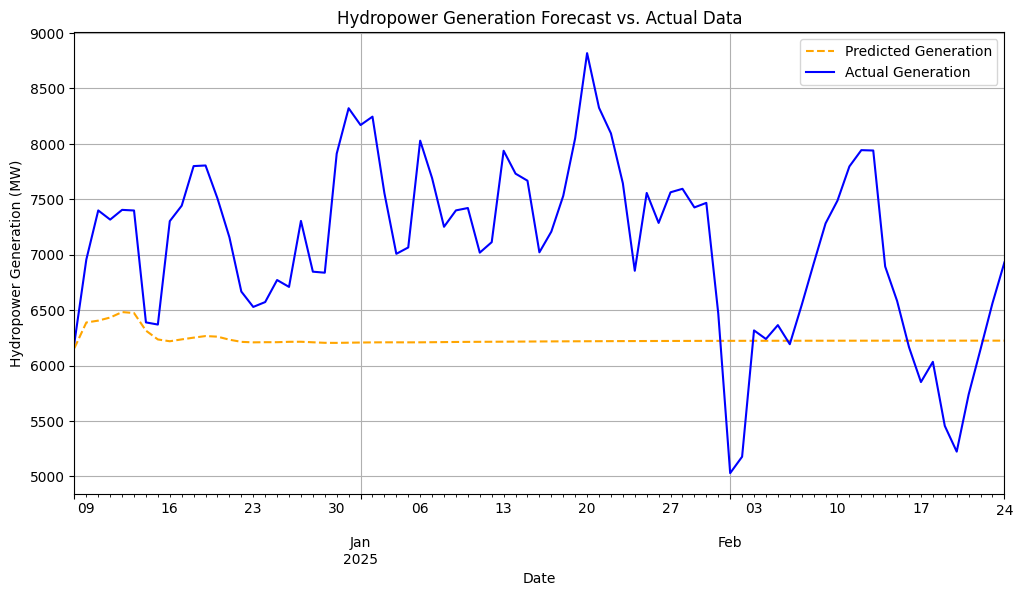

In [18]:
#Plotting prediction vs. actual data
plt.figure(figsize=(12, 6))

# Plot predicted generation values
df_forecast['Generation_pred'].plot(color='orange', linestyle="dashed", label="Predicted Generation")

# Plot actual values
test['Columbia_Projects_Hydro_Generation_MW'].plot(color='blue', label="Actual Generation")

plt.title("Hydropower Generation Forecast vs. Actual Data")
plt.xlabel("Date")
plt.ylabel("Hydropower Generation (MW)")
plt.legend()
plt.grid(True)
plt.show()

## **Performance Evaluation**

- Hydropower generation is influenced by seasonal and operational constraints, which may not be fully captured by a linear model like VAR.
- Sudden fluctuations in discharge values introduce non-linear patterns that VAR does not handle well.
- The predicted line is almost flat. This suggests VAR is not complex enough for long-term forecasting and capturing short-term variations.
- Errors were higher during extreme variations, indicating the model struggles with sudden changes in generation.

In [20]:
score = np.sqrt(mean_squared_error(test['Columbia_Projects_Hydro_Generation_MW'], df_forecast['Generation_pred']))
mae = mean_absolute_error(test['Columbia_Projects_Hydro_Generation_MW'], df_forecast['Generation_pred'])
print(f"RMSE Score on the test set: {score:0.2f}")
print(f"Mean Absolute Error on the test set: {mae:0.2f}")

RMSE Score on the test set: 1149.55
Mean Absolute Error on the test set: 985.87
